In [1]:
from eval import analyze_model

import pandas as pd
import torch
import numpy as np
from pmf import PMF
from lr import LogReg
import pickle

SEED = 42
K_FOLDS = 5
REPLACEMENT_LEVELS = [25, 50, 100, 250, 500, 1000]
LATENT_FACTORS = [1, 2, 3, 4]

c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
df = pd.read_csv('data/men_data.csv')

from sklearn.model_selection import KFold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    for replacement_level in REPLACEMENT_LEVELS:
        with open(f"models/lr/model_rl_{replacement_level}_fold_{fold}.pkl", 'rb') as f:
            lr_model = pickle.load(f)
        for num_factors in LATENT_FACTORS:
            results.append({
                'model_type': 'lr',
                'replacement_level': replacement_level,
                'num_factors': num_factors,
                'fold': fold,
                'train_results': analyze_model(lr_model, train),
                'test_results': analyze_model(lr_model, test)
            })

        for num_factors in LATENT_FACTORS:
            pmf_model = torch.load(f"models/pmf/model_rl_{replacement_level}_d_{num_factors}_fold_{fold}.pth")
            pmf_model.eval()
            results.append({
                'model_type': 'pmf',
                'replacement_level': replacement_level,
                'num_factors': num_factors,
                'fold': fold,
                'train_results': analyze_model(pmf_model, train),
                'test_results': analyze_model(pmf_model, test)
            })

results = pd.DataFrame(results)
results

,model_type,replacement_level,num_factors,fold,train_results,test_results
0,lr,25,1,0,"{'Accuracy': 0.6817173533542468, 'Log Loss': 0...","{'Accuracy': 0.6771670079277576, 'Log Loss': 0..."
1,lr,25,2,0,"{'Accuracy': 0.6817173533542468, 'Log Loss': 0...","{'Accuracy': 0.6771670079277576, 'Log Loss': 0..."
2,lr,25,3,0,"{'Accuracy': 0.6817173533542468, 'Log Loss': 0...","{'Accuracy': 0.6771670079277576, 'Log Loss': 0..."
3,lr,25,4,0,"{'Accuracy': 0.6817173533542468, 'Log Loss': 0...","{'Accuracy': 0.6771670079277576, 'Log Loss': 0..."
4,pmf,25,1,0,"{'Accuracy': 0.7241786656516204, 'Log Loss': 0...","{'Accuracy': 0.7184333490838453, 'Log Loss': 0..."
...,...,...,...,...,...,...
235,lr,1000,4,4,"{'Accuracy': 0.5560718223342258, 'Log Loss': 0...","{'Accuracy': 0.552399453953586, 'Log Loss': 0...."
236,pmf,1000,1,4,"{'Accuracy': 0.7361264241087835, 'Log Loss': 0...","{'Accuracy': 0.7271343064160454, 'Log Loss': 0..."
237,pmf,1000,2,4,"{'Accuracy': 0.7423741271591326, 'Log Loss': 0...","{'Accuracy': 0.7216738422765935, 'Log Loss': 0..."
238,pmf,1000,3,4,"{'Accuracy': 0.7458261143487164, 'Log Loss': 0...","{'Accuracy': 0.7273443242675628, 'Log Loss': 0..."


In [3]:
metrics = pd.concat([
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors', 'fold']],
            results['train_results'].apply(pd.Series).assign(dataset = "train")
        ], axis = 1
    ),
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors', 'fold']],
            results['test_results'].apply(pd.Series).assign(dataset = "test")
        ], axis = 1
    )
])

metrics.head()

,model_type,replacement_level,num_factors,fold,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score,dataset
0,lr,25,1,0,0.681717,0.599237,0.205967,0.731381,0.734017,train
1,lr,25,2,0,0.681717,0.599237,0.205967,0.731381,0.734017,train
2,lr,25,3,0,0.681717,0.599237,0.205967,0.731381,0.734017,train
3,lr,25,4,0,0.681717,0.599237,0.205967,0.731381,0.734017,train
4,pmf,25,1,0,0.724179,0.501139,0.171640,0.777375,0.840539,train


In [4]:
metrics.query('model_type == "pmf" and replacement_level == 500 and num_factors == 3')

,model_type,replacement_level,num_factors,fold,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score,dataset
38,pmf,500,3,0,0.770775,0.449909,0.151323,0.795360,0.860569,train
86,pmf,500,3,1,0.771247,0.449036,0.151105,0.797857,0.860769,train
134,pmf,500,3,2,0.772967,0.446873,0.150218,0.798945,0.862372,train
182,pmf,500,3,3,0.770985,0.447101,0.150460,0.795715,0.862074,train
230,pmf,500,3,4,0.772563,0.446083,0.150014,0.798530,0.862741,train
38,pmf,500,3,0,0.739959,0.805824,0.177826,0.768605,0.811068,test
86,pmf,500,3,1,0.739014,0.892512,0.182163,0.768715,0.804122,test
134,pmf,500,3,2,0.733711,0.870697,0.183246,0.761564,0.801544,test
182,pmf,500,3,3,0.745524,0.819764,0.176175,0.775633,0.814445,test
230,pmf,500,3,4,0.743306,0.844257,0.178287,0.770329,0.810554,test


c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 18 x 9 in image.
c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: results/results.png


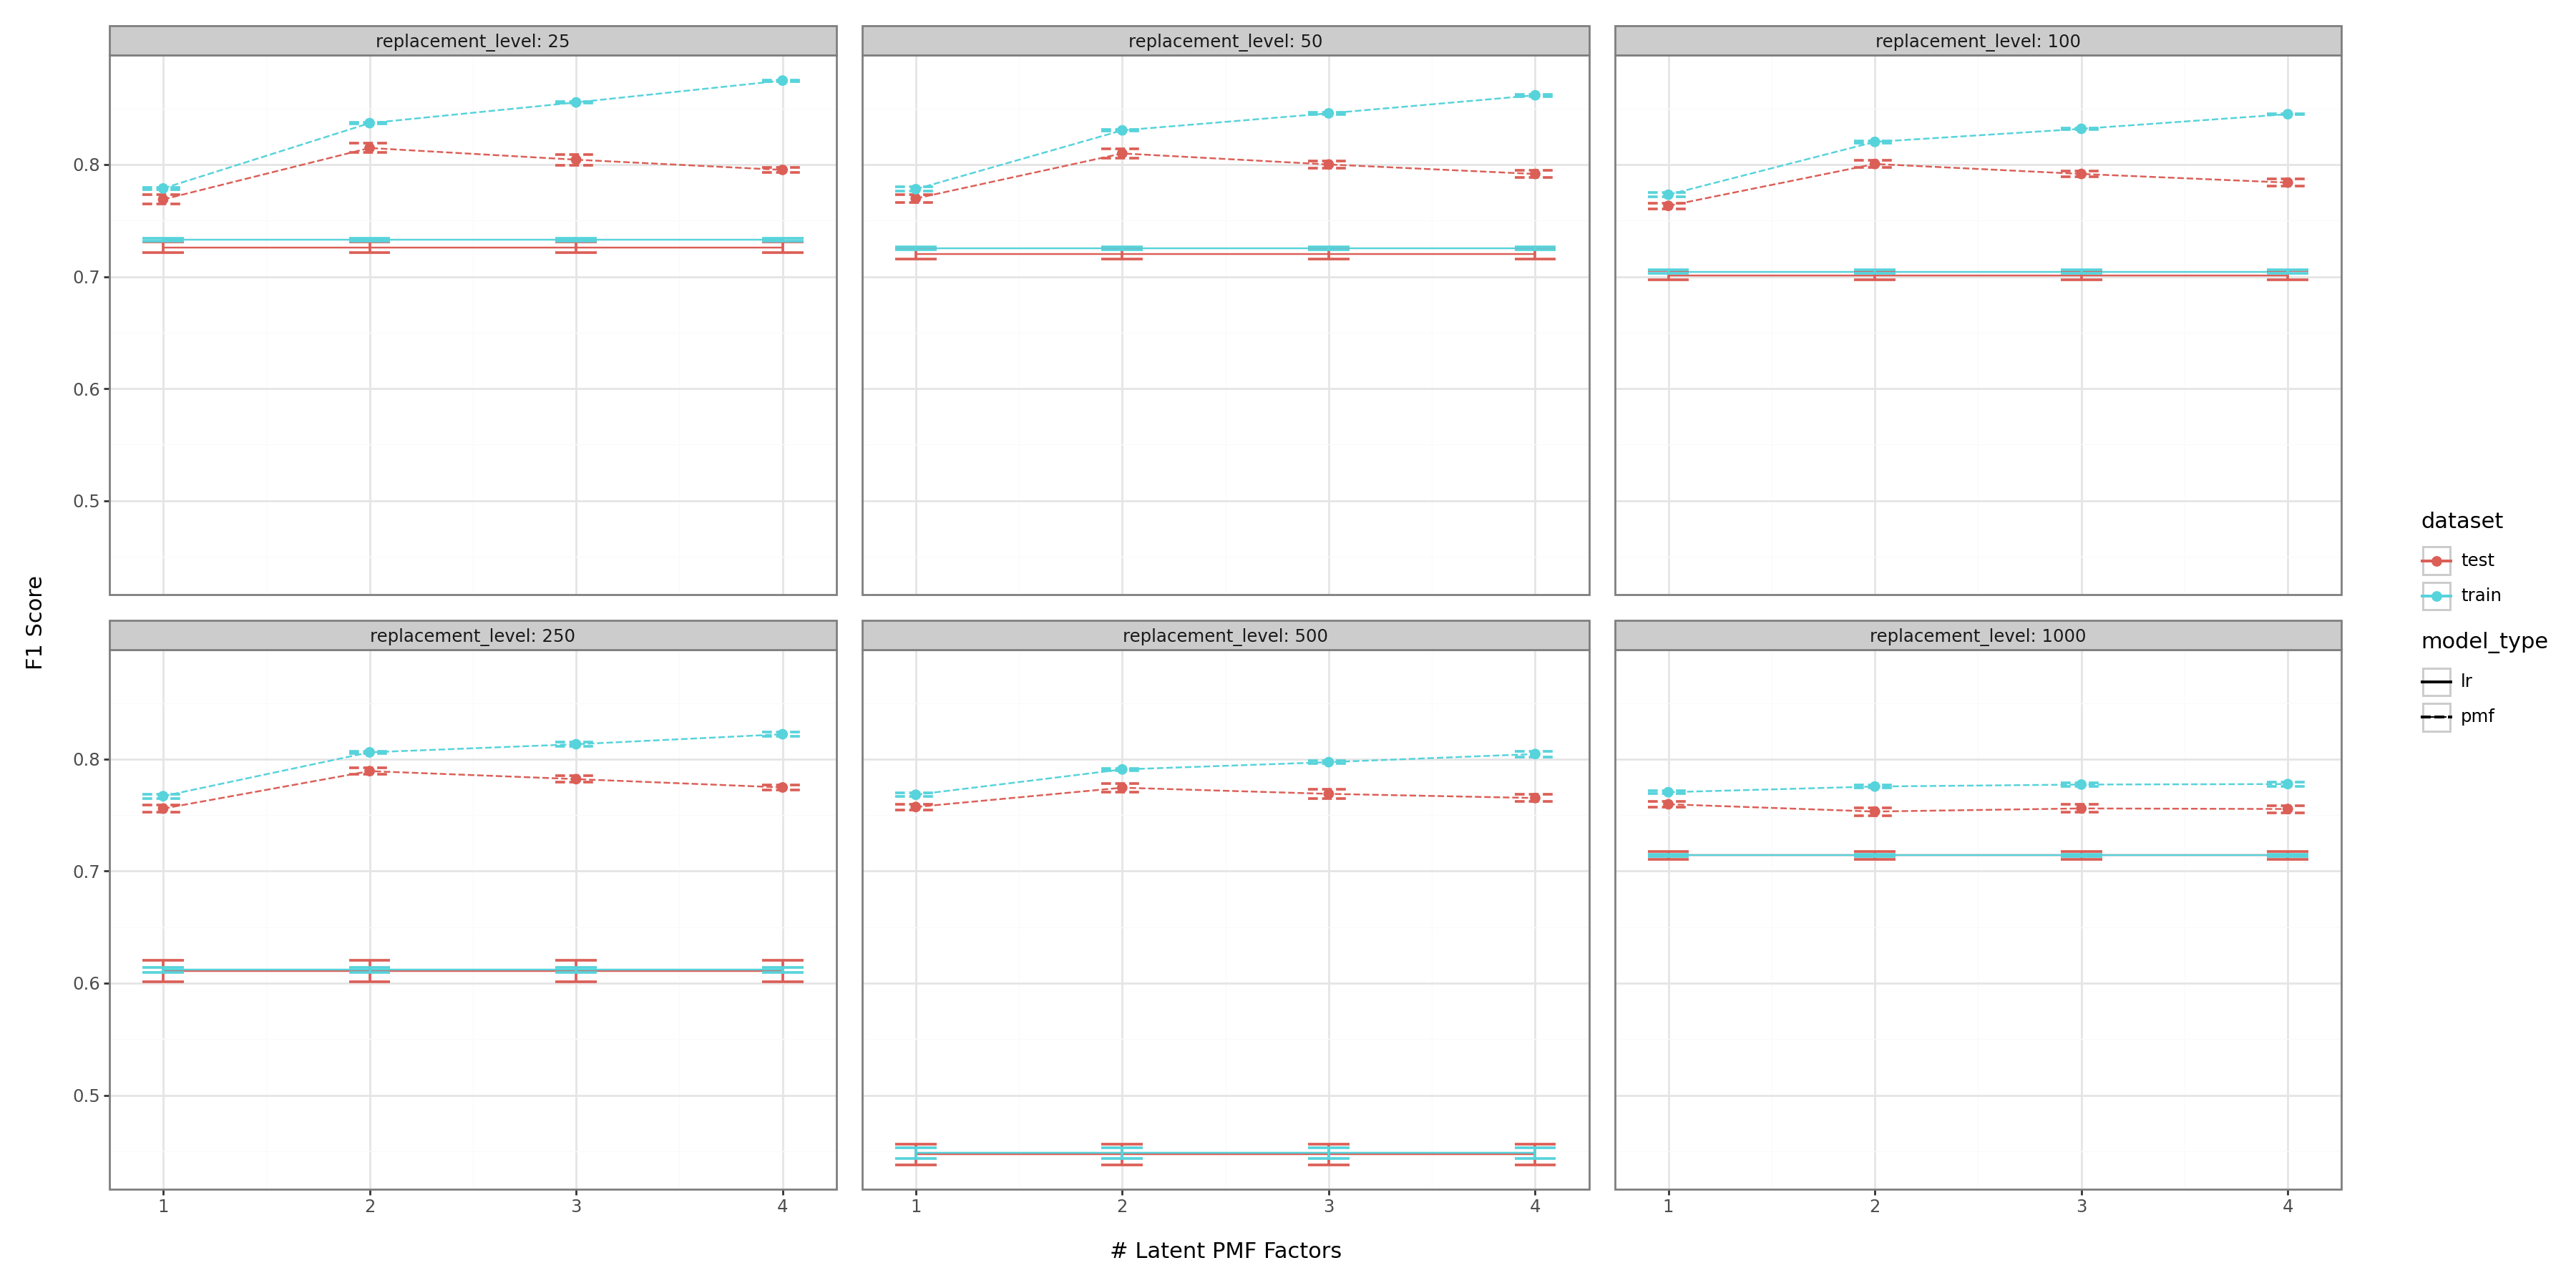

In [5]:
import plotnine
from plotnine import *

plot_data = (
    metrics
    .groupby(['model_type', 'replacement_level', 'num_factors', 'dataset'])
    ['F1 Score'].agg(['mean', 'std', 'size'])
    .reset_index()
    .assign(
        se = lambda d: d['std'] / d['size'].apply(np.sqrt),
        mean_err_min = lambda d: d['mean'] - 1.96 * d.se,
        mean_err_max = lambda d: d['mean'] + 1.96 * d.se
    )
)

plotnine.options.figure_size = (18,9)
p = (
  plot_data
  .pipe(ggplot, aes(x = "num_factors", y = "mean", color = "dataset", linetype = "model_type")) +
  # Add horizontal lines for logistic regression
  # geom_hline(aes(yintercept = "mean", color = "dataset"), data = plot_data.query("model_type == 'lr'")) +
  # Add lines and points for PMF
  geom_line() +
  geom_errorbar(aes(ymin = "mean_err_min", ymax = "mean_err_max"), width = 0.2, size = 0.75) +
  geom_point(size = 2, data = plot_data.query("model_type == 'pmf'")) +
  facet_wrap("~ replacement_level", labeller="label_both") +
  labs(x = "# Latent PMF Factors", y = "F1 Score") +
  theme_bw()
)

p.save("results/results.png")
p